In [176]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from copy import deepcopy
import seaborn as sns
sns.set(font_scale=1.2)
sns.set_style("whitegrid", {'grid.linestyle':'--'})

%matplotlib notebook

## Generate data

In [30]:
from sklearn import cluster, datasets, mixture
# same as http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html
random_state = 42
np.random.seed(random_state)

n_samples = 1000
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=random_state)

# Anisotropicly distributed data
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

In [172]:
def make_plots(data, labels=None, fig_num=0):
    color_pal = sns.color_palette()
    plt.close(fig_num)
    plt.figure(fig_num, figsize=(6,6))
    if labels is not None:
#         colors = [color_pal[x] for x in pred]
        sns.scatterplot(data[:, 0], data[:, 1], hue=labels, alpha=0.3)
    else:
        sns.scatterplot(data[:, 0], data[:, 1], alpha=0.3)
# make_plots(varied[0])

In [364]:
def adjacency(data, pair_wise_fn, distance=True):
    """
    Given a pair wise function, we will calculate
    the full adjacency matrix between all pairs in data.
    
    If the pair wise function is given as distance function,
    the adjaency matrix will be expressed in distance.
    Otherwise, the pair wise function will be treated as similarity,
    and the adjaency matrix will be expressed in similarity.
    
    Input
    ==========
    data: <numpy array>
    pair_wise_fn: <function object>
    """
    
    n = len(data)
    # init an adjacency matrix in ndarray format
    adj_mat = np.array([[0. for _ in range(n)] for _ in range(n)])
    
    # double for loop to calculate all pair-wise distance
    for i in range(n):
        if 100*i%n == 0:  # print progress every now and then
            progress = 100*(n-i+n)*i/n**2
            print('Progress: {:d}%...'.format(int(progress)), end='\r')
        for j in range(i, n):
            w = pair_wise_fn(data[i], data[j])
            adj_mat[i][j] = adj_mat[j][i] = w # distance is symmetrical
    print('Progress: 100%...\nFinished!')
    
    return adj_mat

def gaussian_sim(x, y, sigma=0.1):
    return np.exp(-np.power(euclidean(x, y), 2)/2/(sigma**2))

data = noisy_moons[0]
adj_mat = adjacency(data, gaussian_sim, False)

Progress: 100%...
Finished!


In [252]:
def get_D(adj_mat):
    """
    Get the degree matrix from the adjacency matrix 
    """
    n = len(adj_mat)
    d_mat = np.array(np.array([[0. for _ in range(n)] for _ in range(n)]))
    
    # Get row and column indices of diag elements 
    row, col = np.diag_indices_from(adj_mat)
    d_mat[row, col] = adj_mat.sum(axis=1)
    
    return d_mat

In [365]:
def spectral_clustering(A, k, normalized=None):
    """
    Spectral clustering
    """
    from sklearn.cluster import KMeans
    
    n = len(A)
    D = get_D(A)
    
    # un-normalized graph Laplacian
    L = D - A
    if normalized == 'rw':
        L = np.eye(n) - np.matmul(np.linalg.inv(np.matrix(D)), np.mat(A))
    elif normalized == 'sym':
        D_sqrt_inv = np.linalg.inv(sp.linalg.sqrtm(np.matrix(D)))
        tmp = np.matmul(D_sqrt_inv, np.mat(A))
        L = np.eye(n) - np.matmul(tmp, D_sqrt_inv)
    
    # get the eig values w, and eig vectors v of L
    w, v = np.linalg.eigh(L)
    # get first k eig vectors
    U = np.matrix(v[:, :k])
    
    if normalized == 'sym':
        U_array = np.array(U)
        l2norms = np.sqrt((U_array*U_array).sum(axis=1))
        U = U_array / l2norms.reshape(n, 1)
    
    # clustering rows of U
    km = KMeans(n_clusters=k, max_iter=5*n, n_init=100)
    km.fit(U)
    labels = km.labels_
    
    return labels, w, v

labels, w, v = spectral_clustering(adj_mat, 2, normalized='sym')

<IPython.core.display.Javascript object>


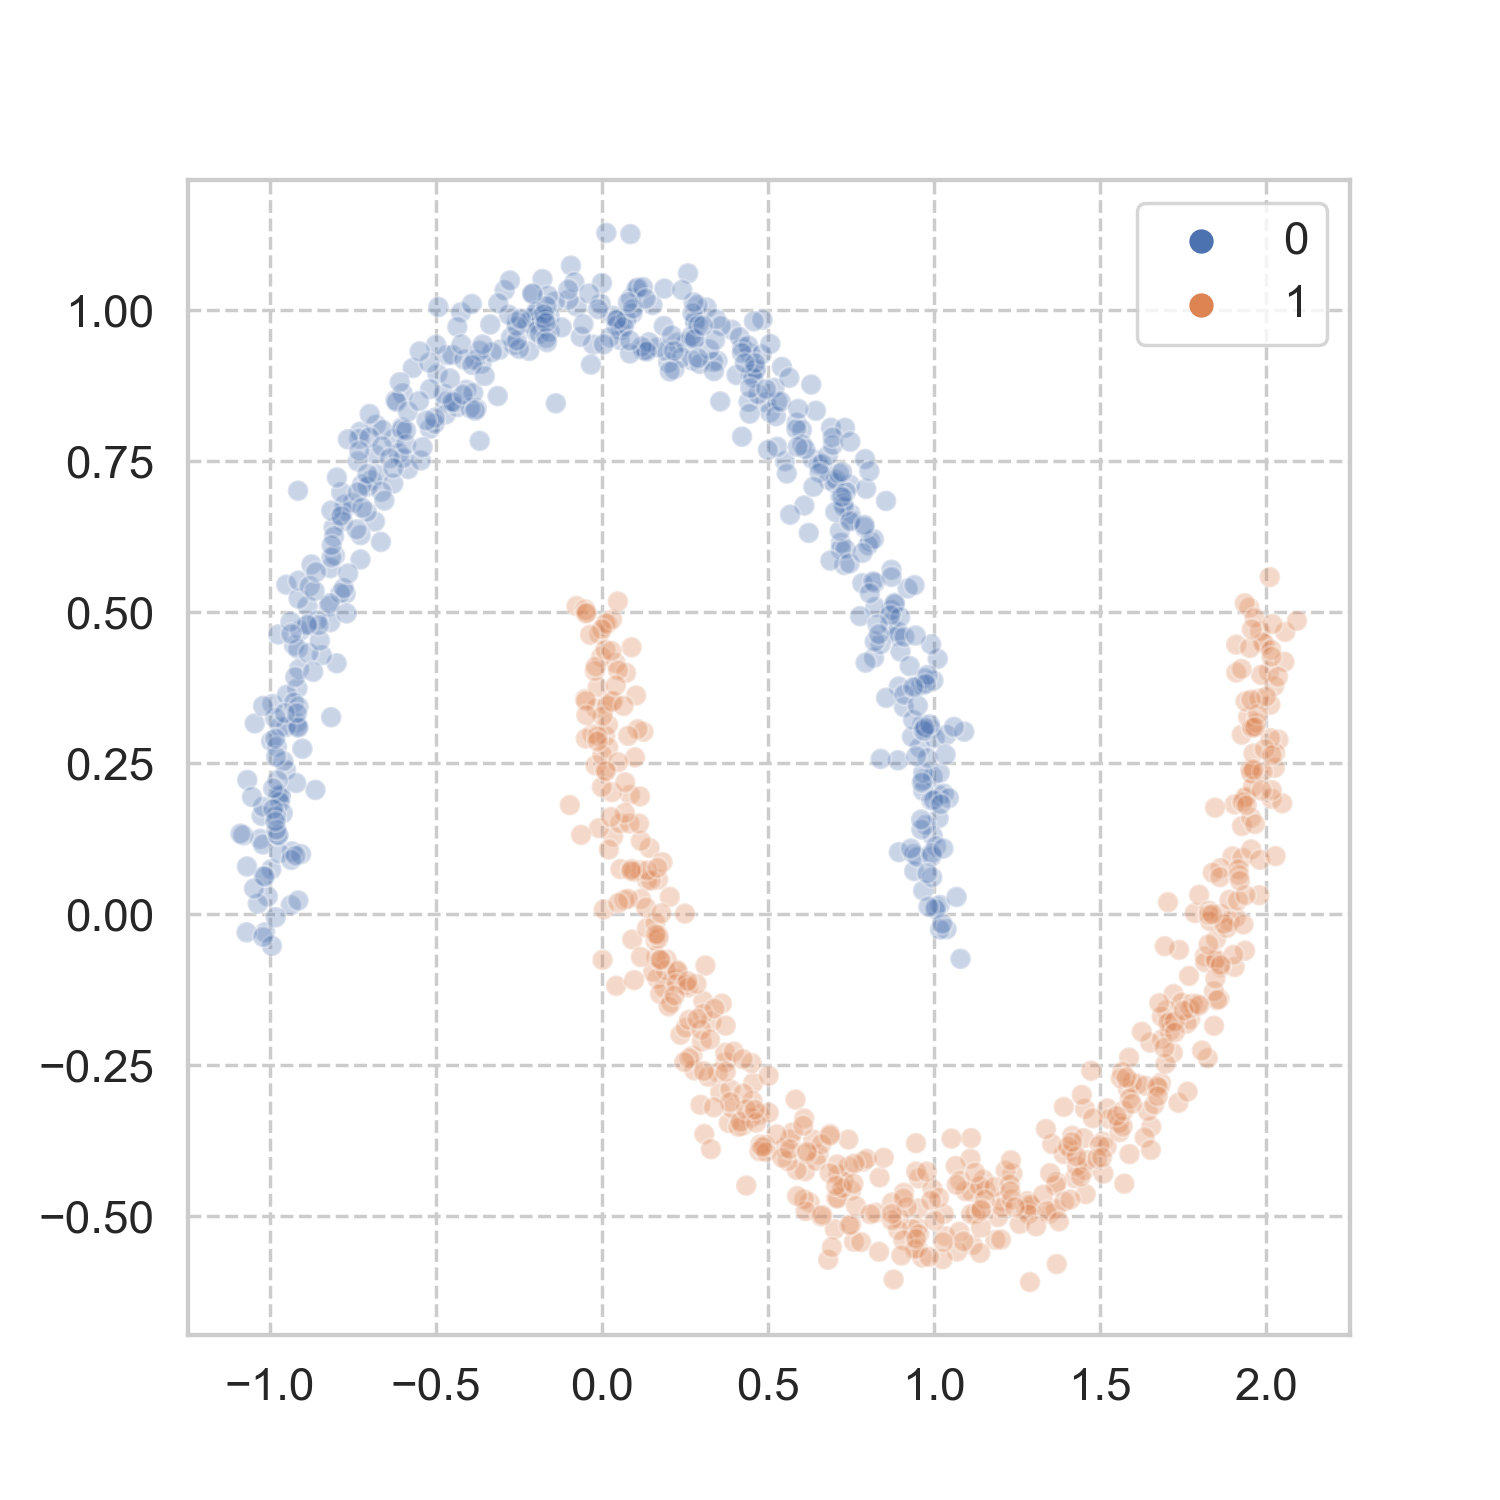

In [366]:
make_plots(data, labels)